# Module 10: Getting the mPDF from magnetic diffraction data

Here, we show how to use the built-in Fourier transform functionalities in diffpy.mpdf to generate mPDF data from magnetic diffraction data. We assume that we have already isolated the magnetic scattering from the nuclear scattering, e.g. by temperature subtraction, the use of polarized neutrons, or some other means. We can use the software to obtain both the non-deconvolved mPDF data (i.e. without normalizing the scattering data by the squared magnetic form factor) and, if the data quality permits, the high-resolution, properly deconvolved mPDF data for which the scattering data are normalized by the squared magnetic form factor. For details about our approach, please see the paper at https://doi.org/10.1063/5.0130400.

Note: You will not typically use the functionalities demonstrated here when you are generating total PDF data, i.e. PDF data containing both the nuclear and magnetic PDF signals.

In [2]:
### Import the necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from diffpy.mpdf import *

### Set all plots to be inline
%matplotlib widget 
# or try %matplotlib notebook

### Example 1: Magnetic PDF data in the ordered state of MnTe

This example uses magnetic scattering data extracted via longitudinal polarization analysis on HYSPEC at the Spallation Neutron Source. The polarization analysis automatically separates the magnetic scattering from the nuclear scattering, so we can generate the mPDF in isolation, without being mixed in with the nuclear PDF. The magnetic scattering data comes from MnTe at 50 K, which is deep in the antiferromagnetically ordered state of this compound.

First, read in and plot the diffraction data.

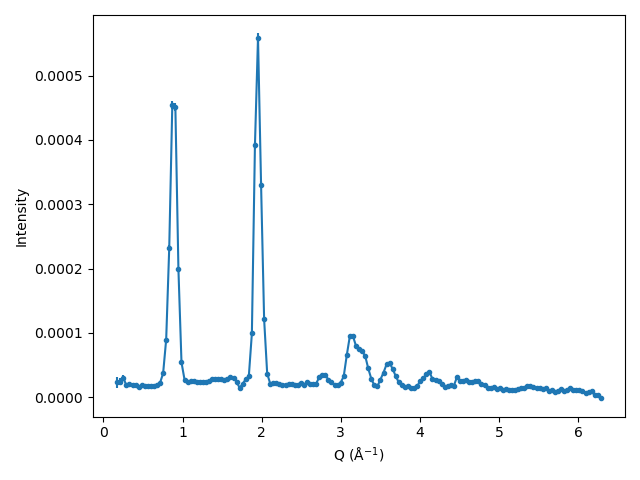

In [3]:
datafile = 'files/IQ_mag_MnTe_50K.txt'

# It's a three-column data format with Q, intensity, and uncertainty separated by commas.
# We skip the first two rows to avoid a formatting irregularity.
q, iq, diq = np.loadtxt(datafile, unpack=True, skiprows=2, delimiter=',')

# plot the data
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_xlabel(r'Q ($\mathrm{\AA^{-1}}$)')
ax.set_ylabel('Intensity')

ax.errorbar(q, iq, yerr=diq, linestyle='-', marker='.')

plt.tight_layout()
plt.show()

Be sure to inspect the data to determine the minimum and maximum Q values containing meaningful data. We will use this later.

Now we can set up our MPDFtransformer object to transform the scattering data and generate the mPDF data. Execute the cell below and read through the docstring to learn about the required and optional arguments.

In [ ]:
MPDFtransformer?

First, we'll generate the non-deconvoluted (i.e. unnormalized) mPDF. This does not require specifying the magnetic form factor, nor does it make use of any of the window function options.

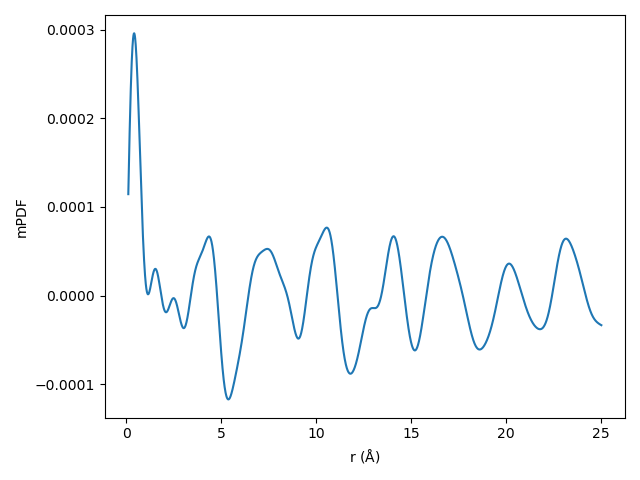

In [7]:
### Create the MPDFtransformer instance and load in the data.
mpdft = MPDFtransformer(q=q, iq=iq, diq=diq)

### Define appropriate qmin and qmax values to be included in the transform.
### Inspect the diffraction data to determine these values. Note that your
### qmax value will often be lower than the actual maximum q value of the
### data due to low statistics or data artifacts at high Q. This is especially
### true when generating the normalized mPDF, which you will do shortly.
mpdft.qmin = 0.2
mpdft.qmax = 6.2

### Set the r-range over which the mPDF should be computed.
mpdft.rmin = 0.1
mpdft.rmax = 25

### Now we can generate the non-deconvolved mPDF, also known as the unnormalized mPDF.
mpdft.getmPDF('unnormalized')

### Plot the result
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_xlabel(r"r ($\mathrm{\AA}$)")
ax.set_ylabel('mPDF')

ax.plot(mpdft.r, mpdft.dmag)

plt.tight_layout()
plt.show()

Let's do a quick fit using the known magnetic structure of MnTe to see how well it does. I'll provide you with the code to do the fit.

In [8]:
def fit(xdata, ydata, fittype):
    """Perform a fit to MnTe mPDF data.
    Plots the fit and returns the calculated mPDF.
    
    xdata = observed r grid
    ydata = observed mPDF
    fittype = 'unnormalized' or 'normalized'
    """
    # read in the mcif, make the MagStructure
    mcif = 'files/0.800_MnTe.mcif'
    mstr = create_from_mcif(mcif, ffparamkey='Mn2', rmaxAtoms=25)
    mstr.struc.lattice.a = 4.193
    mstr.struc.lattice.b = 4.193
    mstr.struc.lattice.c = 6.752
    
    mstr.makeAll()

    # Put the form factor on a q grid that goes to qmax but not beyond
    ffmask = mstr.ffqgrid <= mpdft.qmax
    mstr.ffqgrid = mstr.ffqgrid[ffmask]
    mstr.ff = mstr.ff[ffmask]
    
    # define spin-up and spin-down sublattices for use later on
    sublattice1 = np.all(mstr.spins == mstr.spins[0], axis=1) # select all spins that are identical to the first spin
    sublattice2 = ~sublattice1 # select all other spins 

    ### Create a profile object and load the data into it
    from diffpy.srfit.fitbase import Profile

    profile = Profile()
    profile.setObservedProfile(xdata, ydata)

    ### Create the MPDFcalculator
    mc = MPDFcalculator(mstr)

    ### Set appropriate rmin and rmax
    mc.rmin = profile.xobs.min()
    mc.rmax = profile.xobs.max()

    ### Estimate the qdamp parameter
    mc.qdamp = 0.065
    
    ### Set qmax
    mc.qmax = mpdft.qmax

    ### Make the FitContribution
    from diffpy.srfit.fitbase import FitContribution
    mfit = FitContribution('mfit')
    mfit.setProfile(profile)

    ### Define the function that will calculate the mPDF.
    def mpdf(parascale, ordscale, theta):
        # parascale sets the magnitude of the self-scattering peak below ~1 A
        # ordscale sets the magnitude of the mPDF
        # theta is the polar angle of the spins
        mc.paraScale, mc.ordScale = parascale, ordscale
        # set the new spin direction
        phi = 0
        sx = np.sin(theta) * np.cos(phi)
        sy = np.sin(theta) * np.sin(phi)
        sz = np.cos(theta)
        new_vec = np.array([sx, sy, sz])
        mstr.spins[sublattice1] = new_vec
        mstr.spins[sublattice2] = -new_vec
        rcalc, gcalc, dcalc = mc.calc(both=True)
        if fittype == 'unnormalized':
            return dcalc
        elif fittype == 'normalized':
            return gcalc
        else:
            print("Choose 'unnormalized' or 'normalized' for fittype.")
            return 0*dcalc

    ### Now we load this function into our FitContribution
    mfit.registerFunction(mpdf)

    ### Now we set the equation that the FitContribution will evaluate during the fit
    mfit.setEquation("mpdf(parascale, ordscale, theta)")

    ### Make the FitRecipe
    from diffpy.srfit.fitbase import FitRecipe
    recipe = FitRecipe()

    ### Give the PDFContribution to the FitRecipe
    recipe.addContribution(mfit)

    ### Add the mPDF variables
    recipe.addVar(mfit.parascale, 1) # 1.0 is the starting value
    recipe.addVar(mfit.ordscale, 1)
    recipe.addVar(mfit.theta, np.pi/2)
    restraint_theta = recipe.restrain(mfit.theta,lb=0,ub=np.pi,sig=0.0001) # restrict theta to [0, Pi]

    # Turn off printout of iteration number.
    recipe.clearFitHooks()

    print("Refine using scipy's least-squares optimizer:")
    print("  variables:", recipe.names)
    print("  initial values:", recipe.values)

    from scipy.optimize import least_squares

    # This is where we run the least squares minimization
    optimized = least_squares(recipe.residual, recipe.values)
    print("  final values:", recipe.values)

    ### Plot the results
    fit = mfit.evaluateEquation("mpdf")
    mdiff = ydata - fit

    ax=plt.figure().add_subplot(111)
    ax.plot(xdata, ydata, 'bo', label="mPDF data", markerfacecolor='none', markeredgecolor='b')
    ax.plot(xdata, fit, 'r-', lw=2, label="mPDF fit")
    ax.set_xlabel(r"r ($\AA$)")
    ax.set_ylabel(r"G$_{mag}$ ($\AA^{-2}$)")
    ax.set_xlim(xmax=mc.rmax)
    plt.legend(loc=1)

    plt.show()
    
    return xdata, fit

MagStructure creation from mcif file successful.
Refine using scipy's least-squares optimizer:
  variables: ['parascale', 'ordscale', 'theta']
  initial values: [1.         1.         1.57079633]
  final values: [9.09701487e-04 4.54886088e-04 2.36662637e+00]


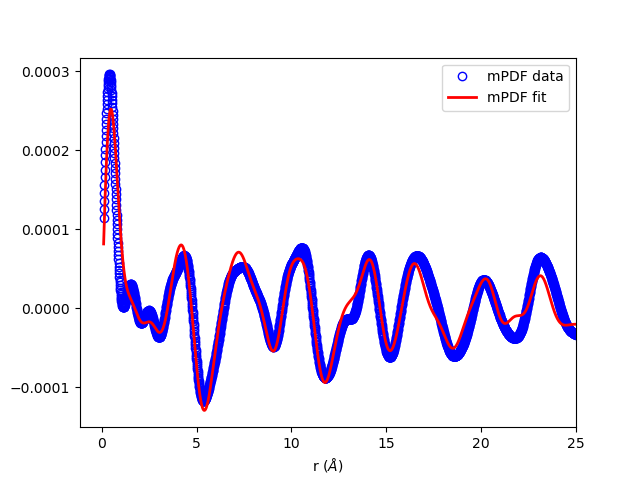

In [9]:
rcalc, rfit = fit(mpdft.r, mpdft.dmag, 'unnormalized')

The data and fit look reasonably good for the non-deconvolved mPDF.

Now we proceed to the deconvolved mPDF, i.e. the normalized mPDF, meaning the diffraction pattern is divided by the squared magnetic form factor before taking the Fourier transform.

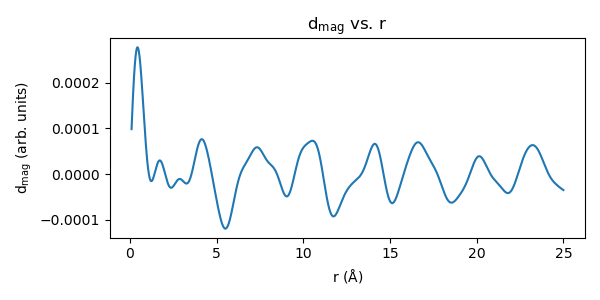

MagStructure creation from mcif file successful.
Refine using scipy's least-squares optimizer:
  variables: ['parascale', 'ordscale', 'theta']
  initial values: [1.         1.         1.57079633]
  final values: [1.         0.31989143 2.22021637]


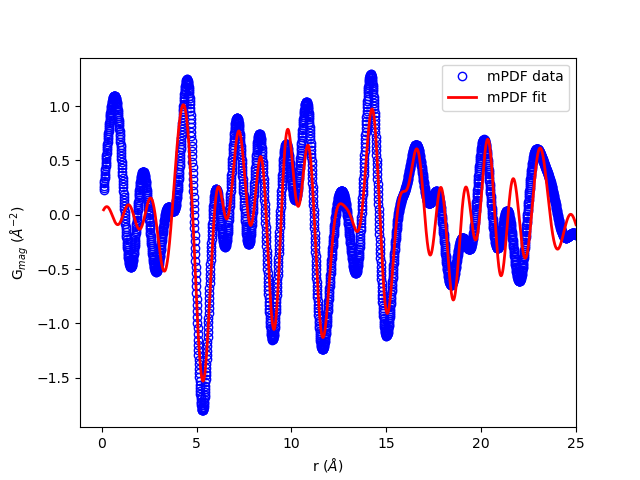

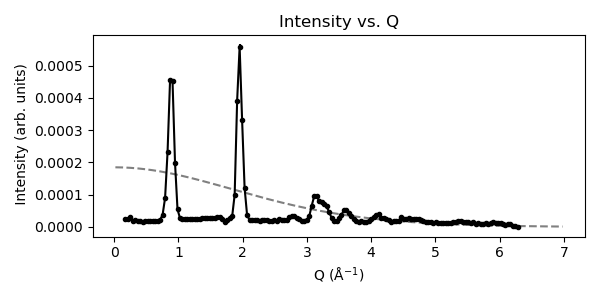

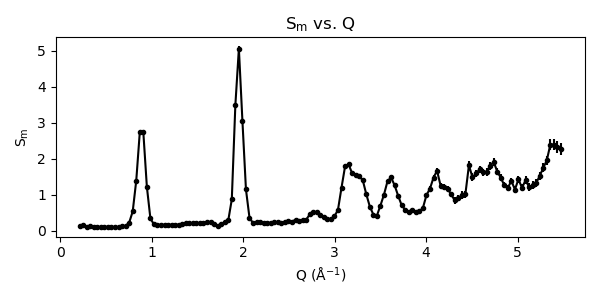

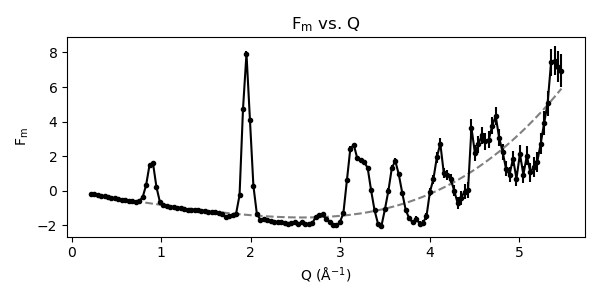

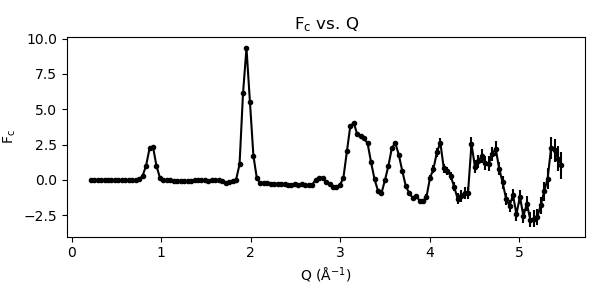

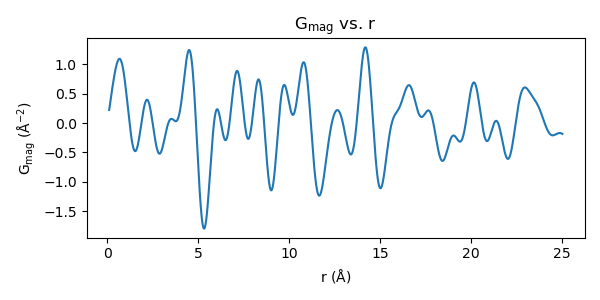

In [10]:
### Define the magnetic form factor for Mn2+.
mpdft.ff = jCalc(q, getFFparams('Mn2'))

### Adjust qmax as necessary to optimize your data quality.
### Try values between 4 and 6.2 A^-1.
mpdft.qmax = 5.5

### Set rpoly for the ad hoc correction. 2 is a typical value, but you
### should try values between 1 and 3. This value should always be
### shorter than the shortest spin pair distance.
mpdft.rpoly = 2

### Set qstart and qmaxinst, which define the q range over
### which the squared form factor will be fit. A reasonable
### range would be 3 - 6 A^-1, but you can play around with this.
mpdft.qstart = 3.0
mpdft.qmaxinst = 6

### Generate the mPDF.
mpdft.getmPDF('unnormalized')
mpdft.getmPDF('normalized')

### Generate plots showing the intermediate steps and the final result.

mpdft.makePlots() # Gmag = deconvolved mPDF, dmag = non-deconvolved mPDF

### Perform a fit to the mPDF data
rcalc, rfit = fit(mpdft.r, mpdft.gmag, 'normalized')

In [11]:
plt.close('all')

### Example 2: Spin glass state of Zn0.5Mn0.5Te

This example uses diffuse magnetic scattering from the spin glass compound Zn0.5Mn0.5Te. The data were collected at 4 K using a conventional powder diffractometer, HB-2A at the High Flux Isotope Reactor. A custom algorithm was used to remove the nuclear Bragg peaks and leave just the diffuse magnetic scattering. Because the algorithm is imperfect, the data quality is a bit lower than that of the previous example using polarized neutrons, so it's a good opportunity to practice with non-ideal data.

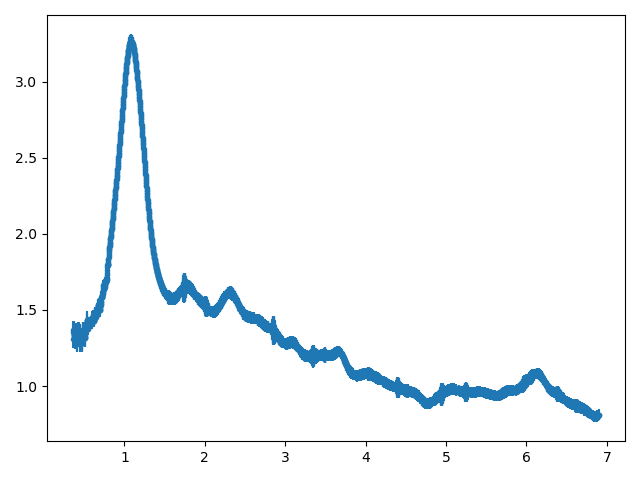

In [12]:
### Read in and plot the diffuse scattering data
q, iq, diq = np.loadtxt('files/ZnMnTe_magscattering_4K.txt',unpack=True)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.errorbar(q, iq, yerr=diq, marker='.', linestyle='None')
plt.tight_layout()
plt.show()

Note that the diffuse scattering plateaus at high Q to a nonzero value, a consequence of the Q-independent incoherent scattering present in nearly all neutron diffraction experiments. We want to remove this incoherent background before doing the Fourier transform. Identify an appropriate constant background level that roughly matches the high-Q data and subtract it from the data. By the way, these data were normalized to absolute units of barns per steradian per magnetic atom. As such, the high-Q asymptote should be the average squared neutron scattering length (averaged over the different types of atoms and their respective concentrations), divided by the concentration of magnetic atoms, which is 0.25 for Zn0.5Mn0.5Te. Feel free to calculate this expected incoherent background level to verify it is consistent with our data.

0.953151428971368


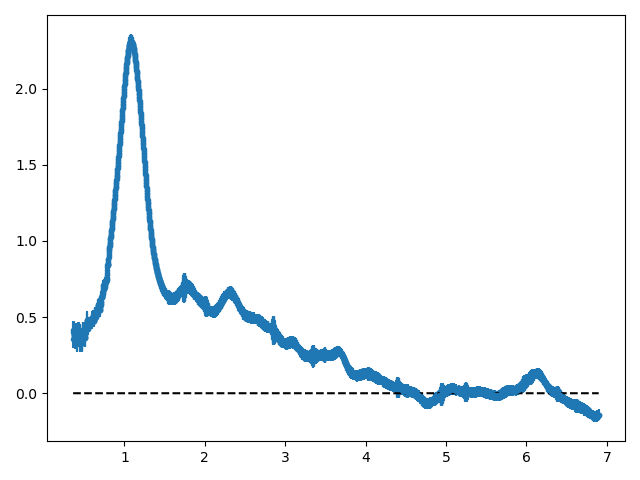

In [19]:
# set the background level
background = np.mean(iq[(4.5 < q) &(q < 6.0)])
print(background)

# subtract the background from the data
newiq = iq - background

# plot the background-corrected data
fig = plt.figure()
ax = fig.add_subplot(111)
ax.errorbar(q, newiq, yerr=diq, marker='.', linestyle='None')
ax.plot(q, 0*q, 'k--')
plt.tight_layout()
plt.show()

Now we can create the MPDFtransformer object and generate the mPDF.

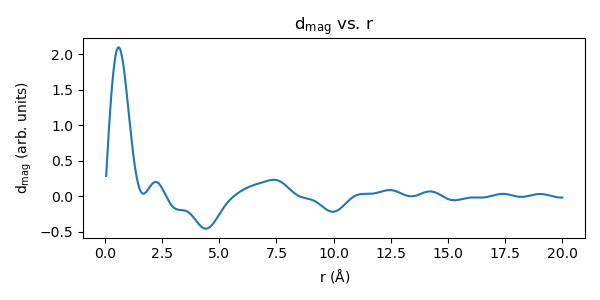

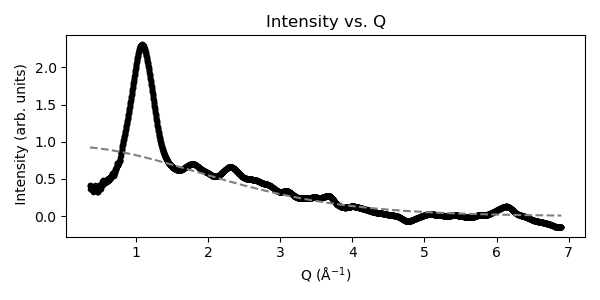

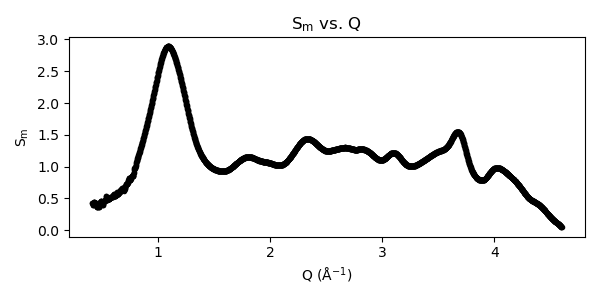

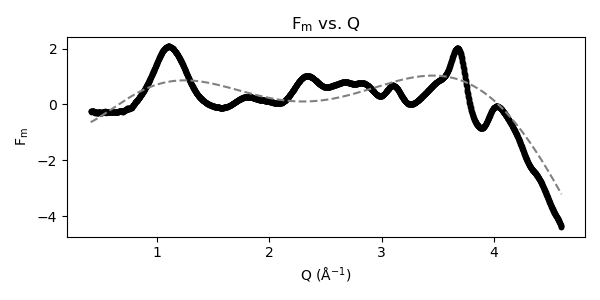

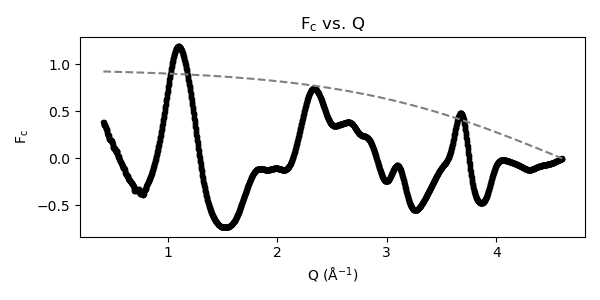

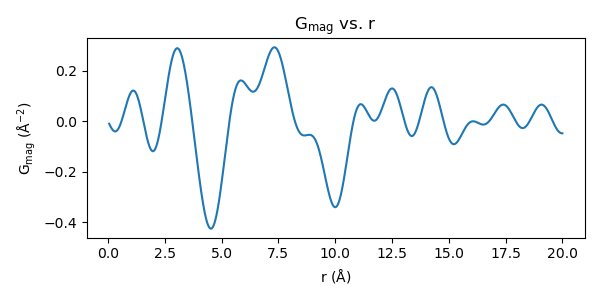

In [20]:
# create the Mn2+ magnetic form factor
ff = jCalc(q, getFFparams('Mn2'))

# set Qmin and Qmax for the transform
qmin = q.min()+0.05
qmax = 4.6

# create the MPDFtransformer instance
mpdft = MPDFtransformer(q, newiq, ff, qmin, qmax, qmaxinst=q.max(),
                        diq=diq, rmax=20)

# set some optional arguments (play around with these values)
mpdft.qstart = 3.0
mpdft.rpoly = 2.5
mpdft.window = 'FD'
mpdft.qmaxwindow = qmax
mpdft.windowedgewidth = 1

# Generate and print the unnormalized mPDF.
mpdft.getmPDF('unnormalized')

# Generate and print the normalized mPDF.
mpdft.getmPDF('normalized')


# Generate several plots showing the data reduction from start to finish.
mpdft.makePlots(showuncertainty=False)

In [84]:
plt.close('all')

### Exercises
 - Go back to the first example and use a value of qmax that is much smaller than optimal, e.g. 2.5 or 3 A-1. How is the mPDF affected? What if you use the largest possible qmax for which you have data, i.e. 6.2 A-1?
 - Generate the mPDF from the second example without first subtracting the background level. How does this affect the mPDF data?
 - In Zn0.5Mn0.5Te, the Mn atoms are randomly distributed on a face-centered cubic lattice with conventional lattice parameter 6.22 A. Calculate the first three Mn-Mn distances and compare them to the mPDF data to determine the nature of these near-neighbor spin correlations. (Note that the peaks in the mPDF may not line up perfectly with the interatomic distances you calculate due to the effect of a limited qmax.)

Solution to third exercise:

4.3982041789803255 6.22 7.617913100055683


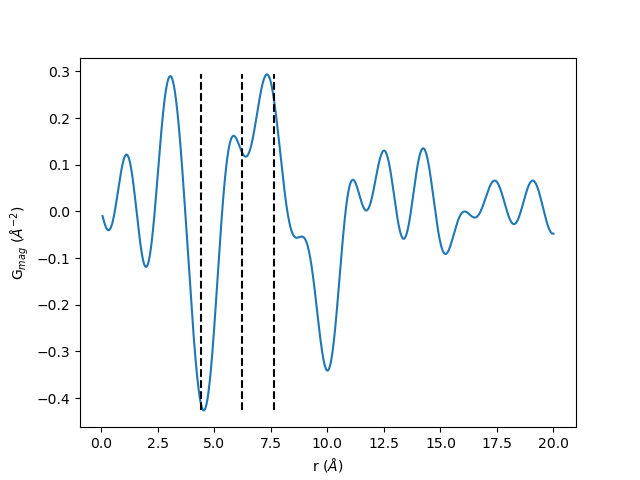

In [21]:
a = 6.22
d1 = np.sqrt(1/2)*a
d2 = np.sqrt(2/2)*a
d3 = np.sqrt(3/2)*a
print(d1, d2, d3)

fig = plt.figure()
ax=fig.add_subplot(111)
ax.plot(mpdft.r, mpdft.gmag)
ax.vlines([d1, d2, d3], [mpdft.gmag.min()]*3, [mpdft.gmag.max()]*3, linestyle='--', color='k')
ax.set_xlabel(r"r ($\AA$)")
ax.set_ylabel(r"G$_{mag}$ ($\AA^{-2}$)")

plt.show()

Nearest-neighbor spins are antiferromagnetically aligned, 2nd and 3rd nearest-neighbors are ferromagnetically aligned.